# Estimating the Proc2D mean in the Cov.-Smoothing Basis

Import libraries.

In [2]:
# Required
library(mgcv)
library(sparseFLMM)
library(dplyr)

# To deal with SRV framework
#detach("package:elasdics2d", unload=TRUE)
devtools::install("../../elasdics")
library(elasdics2d)

# Plotting
library(ggplot2)
library(gridExtra)
library(viridis)
library(rgl)
library(fields)

# Datasets
source("../scripts/load_datasets.R")

Loading required package: nlme

This is mgcv 1.8-34. For overview type 'help("mgcv-package")'.

Loading required package: refund


Attaching package: 'dplyr'


The following object is masked from 'package:nlme':

    collapse


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




Skipping 1 packages not available: numDeriv



v  checking for file 'D:\Dropbox\Statistik\elasdics/DESCRIPTION' (355ms)
-  preparing 'elasdics2d': (1.5s)
v  checking DESCRIPTION meta-information
-  checking for LF line-endings in source and make files and shell scripts
-  checking for empty or unneeded directories
-  building 'elasdics2d_0.1.0.tar.gz'
   
Running "C:/R/R-4.0.5/bin/x64/Rcmd.exe" INSTALL \
  "C:\Users\manue\AppData\Local\Temp\Rtmpg1knIZ/elasdics2d_0.1.0.tar.gz" \
  --install-tests 
* installing to library 'C:/R/R-4.0.5/library'
* installing *source* package 'elasdics2d' ...
** using staged installation
** R
** tests
** byte-compile and prepare package for lazy loading
** help
No man pages found in package  'elasdics2d' 
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
*** arch - i386
*** arch - x64
** testing if installed package can be loaded from final location
*** arch - i386
*** arch - x64
** testing if installed package keeps a record o


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Loading required package: viridisLite

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.6-0 (2020-12-14) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



## Prepare Dataset
Load dataset and transform curves to SRV framework.

In [34]:
# Seed 
set.seed(18)

# Simulate 2D spirals.
data_curves <- curves.spiral(n_curves=4, rotate=TRUE, scale=TRUE, center=TRUE)
#data_curves <- curves.digit3(rotate=TRUE, scale=TRUE, center=TRUE)

# Create arc length parametrization.
data_curves <- lapply(data_curves, function(data_curve) {
    data.frame(t = get_arc_length_param(data_curve), data_curve)
})

normalize_curve <- function(curve) {
    dx = diff(curve$X1)
    dy = diff(curve$X2)
    dt = diff(curve$t)
    l = sum(sqrt(dx^2 + dy^2))
    curve$X1 = curve$X1 / l
    curve$X2 = curve$X2 / l
    curve
}

data_curves <- lapply(data_curves, normalize_curve)

# Get SRV data curves.
srv_data_curves <- lapply(data_curves, get_srv_from_points)

Get model data!

In [408]:
# Reparametrize SRV data curves and put curves into long (stacked) format.
knots = seq(0, 1, length=16) 
type = "smooth"
h = 0.01  # arg.grid step size
t_optims <- lapply(srv_data_curves, function(srv_data_curve) { c(srv_data_curve$t, 1) })
model_data_complex <- elasdics2d:::get_model_data_complex(t_optims, srv_data_curves, knots, type=type)

TEMP TEMP TEMP Normalize SRV data curves.

In [409]:
# Create curve id column for model_data. (hacky!)
#ids <- do.call(c, lapply(t_optims, function(x) length(x)-1))
#ids <- rbind(1:length(ids), ids)
#ids <- apply(ids, 2, function(x) rep(x[1], times = x[2]))
#ids <- do.call(c, as.list(ids))         
             
# x,y to complex. Add id column.
#model_data_complex <- complex(re=model_data[,2], im=model_data[,3]) %>% matrix(nrow=dim(model_data)[1])
#model_data_complex <- data.frame(id = ids, m_long = model_data$m_long, q_m_long = model_data_complex)

srv_data_curves <- lapply(1:length(srv_data_curves), function(j) {

    q <- model_data_complex[model_data_complex$id == j,]
    if(j==1){
        print(q)
    }
    t1 <- q$m_long[1]
    tn <- q$m_long[length(q$m_long)]
    arg.grid.x <- seq(2*t1, 2*tn-1, by=h)

    # Linear interpolation of srv data curve on overlap.
    q_approx_x <- approx(x=q$m_long, y=Re(q$q_m_long), xout=arg.grid.x)$y
    q_approx_y <- approx(x=q$m_long, y=Im(q$q_m_long), xout=arg.grid.x)$y
    q_approx <- complex(real=q_approx_x, imaginary=q_approx_y)
    
    qq <- Conj(q_approx) * q_approx
    qq1 <- Conj(q$q_m_long[1]) * q$q_m_long[1]
    qqn <- Conj(q$q_m_long[length(q$q_m_long)]) * q$q_m_long[length(q$q_m_long)]
    
    # Numerical Integration using trapezoid rule.
    qq <- h * ( sum(qq) - 0.5*qq[1] - 0.5*qq[length(qq)] ) + 2*t1*qq1 + 2*(1-tn)*qqn
    qq <- Re(qq)
    
    srv <- srv_data_curves[[j]]
    srv[-1] <- srv[-1] / sqrt(qq)
    srv
})

   id     m_long              q_m_long
1   1 0.01217853  0.9739195+0.5153966i
2   1 0.04774175 -0.1452871+1.0922657i
3   1 0.10410260 -1.0657311+0.2799466i
4   1 0.17569727 -0.5473271-0.9563398i
5   1 0.26225496  0.7787965-0.7795055i
6   1 0.36307036  0.9414676+0.5725308i
7   1 0.48222851 -0.0665566+1.0998741i
8   1 0.61656147 -1.0057599+0.4501109i
9   1 0.75608383 -0.6859964-0.8623003i
10  1 0.91377757  0.4589202-1.0017710i


Transform curves from real plane to complex. Add a curve id column (for the covariance estimation).

In [410]:
# Create curve id column for model_data. (hacky!)
#ids <- do.call(c, lapply(t_optims, function(x) length(x)-1))
#ids <- rbind(1:length(ids), ids)
#ids <- apply(ids, 2, function(x) rep(x[1], times = x[2]))
#ids <- do.call(c, as.list(ids))         
             
# x,y to complex. Add id column.
#model_data_complex <- complex(re=model_data[,2], im=model_data[,3]) %>% matrix(nrow=dim(model_data)[1])
#model_data_complex <- data.frame(id = ids, m_long = model_data$m_long, q_m_long = model_data_complex)
model_data_complex <- elasdics2d:::get_model_data_complex(t_optims, srv_data_curves, knots, type=type)

## Estimate Covariance Surface
Build covariance response on (s,t) grid.

In [411]:
cov_dat <- lapply(split(model_data_complex, model_data_complex$id), function(x) {
    combs <- combn(1:nrow(x),2)
    data.frame(
        qq = x$q_m_long[combs[1,]] * Conj(x$q_m_long[combs[2,]]) / (length(srv_data_curves)-1),
        s = x$m_long[combs[1,]],
        t = x$m_long[combs[2,]]
    )
})
cov_dat <- do.call(rbind,cov_dat)

Fit covariance surface using ```mgcv```.

In [412]:
# Parameters for covariance smoothing
#type = "polygon"
#knots = seq(0, 1, length=21) 
cov.m = ifelse(type == "smooth", 0, -1)  # spline degree - 1
cov.d = 2 # penalty

# Build knots
knotl = 1 / ( length(knots) - 1 )  # mean length of a knot
cov.knots = c(rep(-knotl,cov.m+1), knots, rep(1+knotl,cov.m+1))  # asusmes cov.m is 0 or 1.
#cov.knots = c(rep(0,cov.m+1), knots, rep(1,cov.m+1))  # knots at 0,1
cov.k = length(cov.knots) - cov.m - 2 # basis dimension.

# Smooth covariance surface
cov_fit_re <- bam(Re(qq) ~ s(s, t , bs="symm", k = cov.k, m = c(cov.m, cov.d),
                            fx = FALSE, xt = list(skew = FALSE)),
                  data = cov_dat, method = "REML", knots=list(s = cov.knots, t = cov.knots))
cov_fit_im <- bam(Im(qq) ~ -1 + s(s, t, bs="symm", k = cov.k, m = c(cov.m, cov.d),
                                  fx = FALSE, xt = list(skew = TRUE)),
                  data = cov_dat, method = "REML", knots=list(s = cov.knots, t = cov.knots))

Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"


Plot covariance surface on a grid.

In [413]:
# Define covariance surface grid (s,t).
arg.grid = seq(0, 1, by=h)
cov.grid = expand.grid(t = arg.grid, s = arg.grid)
# Evaluate fit on grid.
cov.re = predict(cov_fit_re, newdata = cov.grid)
cov.im = predict(cov_fit_im, newdata = cov.grid)

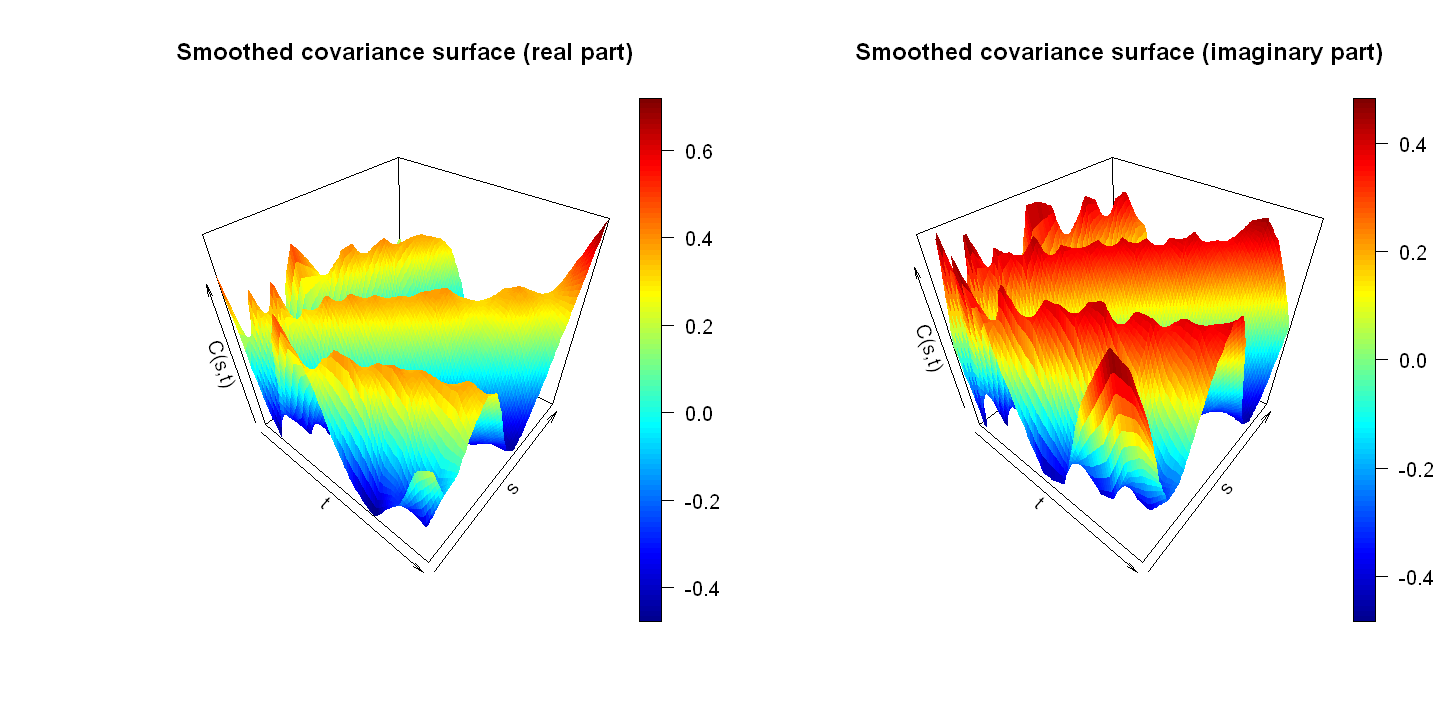

In [414]:
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2), mar=c(4,4,4,1), oma=c(0.5,0.5,0.5,0))
# From 'fdapace/src/R/CreateCovPlot.R'
args1 <- list(
    xlab='t', ylab='s', zlab = 'C(s,t)',
    main = 'Smoothed covariance surface (real part)'
)
args2 = list (x = arg.grid, y = arg.grid, z = matrix(cov.re,nrow=101))
do.call(plot3D::persp3D, c(args2, args1))

# From 'fdapace/src/R/CreateCovPlot.R'
args1 <- list(
    xlab='t', ylab='s', zlab = 'C(s,t)',
    
    main = 'Smoothed covariance surface (imaginary part)'
)
args2 = list (x = arg.grid, y = arg.grid, z = matrix(cov.im,nrow=101))
do.call(plot3D::persp3D, c(args2, args1))

## Estimate Procrustes Mean Shape in fixed Basis
Check basis functions from covariance smoothing.

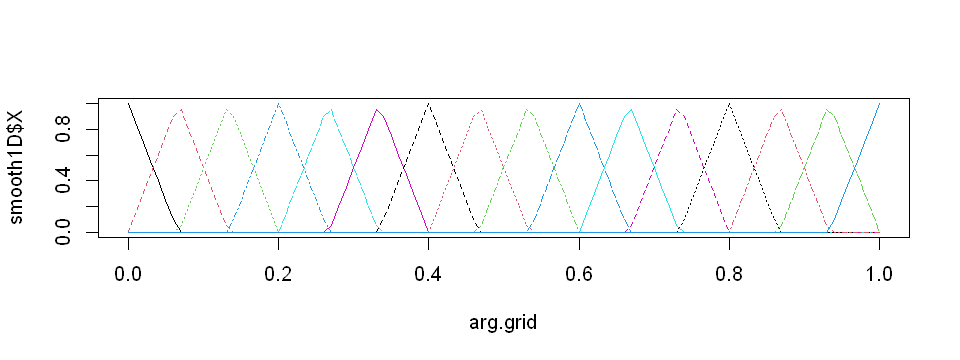

In [415]:
smooth1D <- smooth.construct(s(t, bs="ps", k = cov.k, m = c(cov.m, cov.d),
                              fx = FALSE),
                            data = list(t=arg.grid), knots=list(t=cov.knots))
options(repr.plot.width=8, repr.plot.height=3)
matplot(arg.grid, smooth1D$X, t = "l")

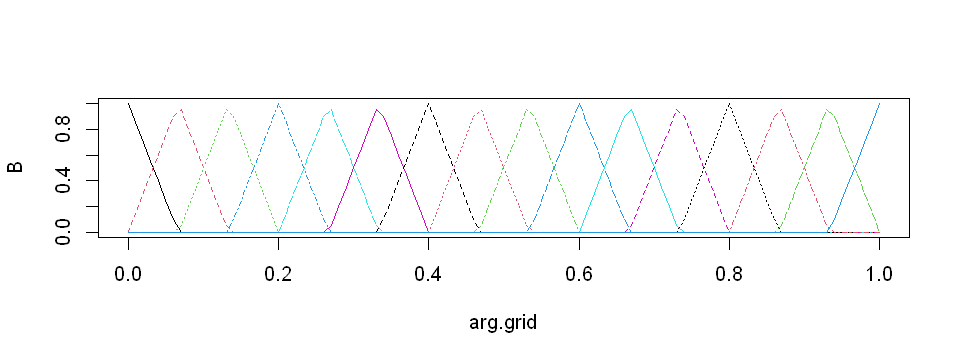

In [416]:
B = elasdics2d:::make_design(arg.grid, knots, type = type)
matplot(arg.grid, B, t = "l")

#### Extract coefficient matrix from mgcv smooth.

In [417]:
get_coef_matrix <- function(model){
    F <- model$smooth[[1]]$bs.dim
    beta <- model$smooth[[1]]$Z %*% model$coefficients
    matrix(beta, nrow=F, ncol=F)
}

In [418]:
build_gram_matrix <- function(smooth){
    order = smooth$m[1] + 2  # degree + 1
    knots = smooth$knots  # inner+outer knots
    if( order == 1 ){
        diag(smooth$bs.dim)
    } else {
        osb_smooth = orthogonalsplinebasis::SplineBasis(knots,order=order)
        orthogonalsplinebasis::GramMatrix(osb_smooth)
    }
}

G <- build_gram_matrix(smooth1D)

In [419]:
beta.mat.re <- get_coef_matrix(cov_fit_re)
beta.mat.im <- get_coef_matrix(cov_fit_im)

beta.mat <- matrix( 
    complex(real = as.vector(beta.mat.re), imaginary = as.vector(beta.mat.im)),
    ncol = cov.k
)

beta.mat.inv = solve(beta.mat)

## PCA on coef matrix
#### A. PCA on big coef mat (identifying $\mathbb{C}^k$ with $\mathbb{R}^{2k}$)

In [420]:
# build big matrix
big.beta.mat <- cbind(c(1,0), c(0,1)) %x% (Re(beta.mat) %*% G) + cbind(c(0,-1), c(1,0)) %x% (Im(beta.mat) %*% G)
pca.stacked <- eigen(big.beta.mat)
coefs.mean.stack <- pca.stacked$vectors[,1]
coefs.mean.compl <- complex(real = coefs.mean.stack[seq(1,dim(beta.mat)[1])], imaginary = coefs.mean.stack[seq(1,dim(beta.mat)[1]) + dim(beta.mat)[1]])

In [421]:
# Check if is unitlength. Whyyyy?
as.numeric(Re(t(Conj(coefs.mean.compl)) %*% G %*% coefs.mean.compl))

[1] 0.06219645

In [422]:
coefs.mean.compl <- coefs.mean.compl / as.numeric(sqrt(Re(t(Conj(coefs.mean.compl)) %*% G %*% coefs.mean.compl )))

In [423]:
qt <- elasdics2d:::make_design(arg.grid, knots, type = type) %*% coefs.mean.compl
qt.xy <- data.frame(t=arg.grid, X1=Re(qt), X2=Im(qt))
bt.xy <- get_points_from_srv(qt.xy)
bt.xy <- center_curve(bt.xy)

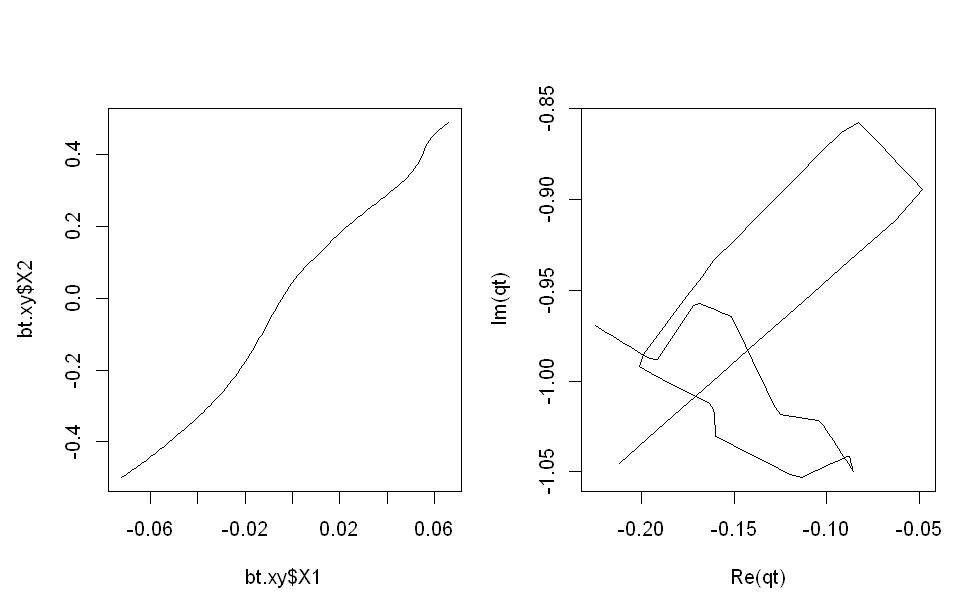

In [424]:
options(repr.plot.width=8, repr.plot.height=5)
par(mfrow=c(1,2), mar=c(4,4,4,1), oma=c(0.5,0.5,0.5,0))
matplot(bt.xy$X1, bt.xy$X2, t="l")
matplot(Re(qt), Im(qt), t="l")

#### B. PCA on complex coef matrix.

In [431]:
# Calculate largest eigenvector
pca <- eigen(t(chol(G)) %*% beta.mat %*% chol(G))
coefs.mean <- solve(t(chol(G))) %*% Conj(pca$vectors[,1])
#pca <- eigen(beta.mat)
#coefs.mean <- Conj(pca$vectors[,1])

In [432]:
# Check if is unitlength. Whyyyy?
as.numeric(Re(t(Conj(coefs.mean)) %*% G %*% coefs.mean))

[1] 1.007157

In [433]:
# Check eigenvalues
c(pca$values)

[1]  0.3653431575  0.0503161491  0.0319418884  0.0104907567  0.0021970757
 [6]  0.0009598177  0.0003071987 -0.0001748762 -0.0013412758 -0.0020546532
[11] -0.0039229469 -0.0071023668 -0.0126102109 -0.0288690596 -0.0724950727
[16] -0.4131433073

In [434]:
coefs.mean <- coefs.mean / as.numeric(sqrt(Re(t(Conj(coefs.mean)) %*% G %*% coefs.mean )))

In [435]:
qt <- elasdics2d:::make_design(arg.grid, knots, type = type) %*% coefs.mean
qt.xy <- data.frame(t=arg.grid, X1=Re(qt), X2=Im(qt))
bt.xy <- get_points_from_srv(qt.xy)
bt.xy <- center_curve(bt.xy)

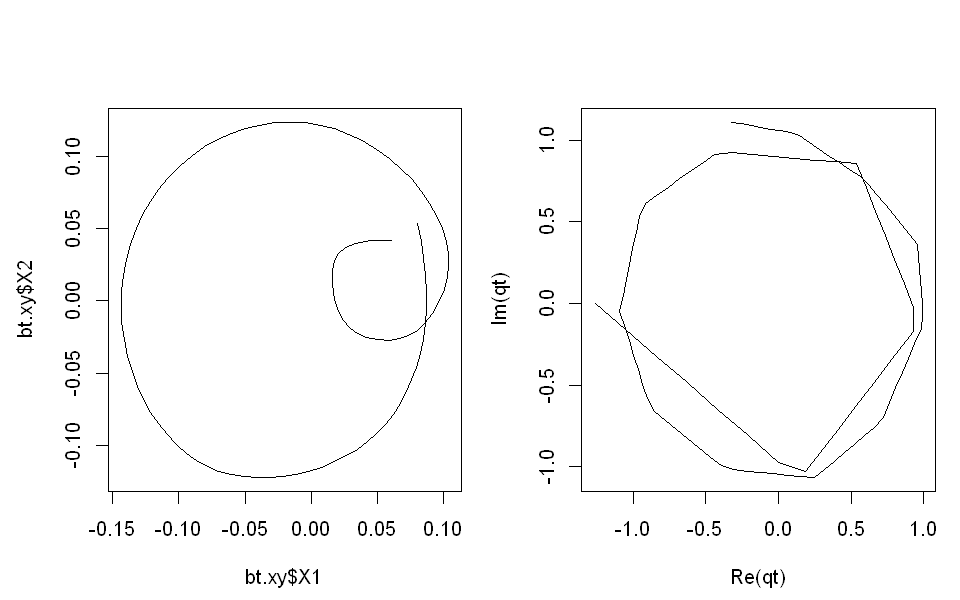

In [436]:
options(repr.plot.width=8, repr.plot.height=5)
par(mfrow=c(1,2), mar=c(4,4,4,1), oma=c(0.5,0.5,0.5,0))
matplot(bt.xy$X1, bt.xy$X2, t="l")
matplot(Re(qt), Im(qt), t="l")

### Plot Procrustes Fits + Mean from fixed basis (Note: No warping!)

Interpolated pfits

In [437]:
q <- model_data_complex[model_data_complex$id == 1,]
t1 <- q$m_long[1]
tn <- q$m_long[length(q$m_long)]
arg.grid.x <- seq(2*t1, 2*tn-1, by=h)
q_approx_x <- approx(x=q$m_long, y=Re(q$q_m_long), xout=arg.grid.x)$y
q_approx_y <- approx(x=q$m_long, y=Im(q$q_m_long), xout=arg.grid.x)$y
q_approx <- complex(real=q_approx_x, imaginary=q_approx_y)
qq <- Conj(q_approx) * q_approx
qq1 <- Conj(q$q_m_long[1]) * q$q_m_long[1]
qqn <- Conj(q$q_m_long[length(q$q_m_long)]) %*% q$q_m_long[length(q$q_m_long)]

int_qq <- h * ( sum(qq) - 0.5*qq[1] - 0.5*qq[length(qq)] ) + 2*t1*qq1 + 2*(1-tn)*qqn
int_qq

1+0i


In [438]:
pfits <- lapply(1:length(srv_data_curves), function(j) {
    
    q <- model_data_complex[model_data_complex$id == j,]
    
    # Calculate overlap of arg.grid and t_optims.
    idx <- findInterval(arg.grid, q$m_long)
    idx.bool <- which(idx > 0 & idx < length(q$m_long))
    arg.grid.x <- arg.grid[idx.bool]
    
    # Size of overlap.
    Dt <- arg.grid.x[length(arg.grid.x)] - arg.grid.x[1]
    
    # Linear interpolation of srv data curve on overlap.
    q_approx_x <- approx(x=q$m_long, y=Re(q$q_m_long), xout=arg.grid.x)$y
    q_approx_y <- approx(x=q$m_long, y=Im(q$q_m_long), xout=arg.grid.x)$y
    q_approx <- complex(real=q_approx_x, imaginary=q_approx_y)
    
    # Evaluate mean function on overlap.
    mean_eval <- elasdics2d:::make_design(arg.grid.x, knots=knots, closed = FALSE, type = type) %*% coefs.mean
    
    # Calculate pfit scaling+rotation
    qm <- Conj(q_approx) * mean_eval
    qq <- Conj(q_approx) * q_approx
    
    # Numerical Integration using trapezoid rule.
    qm <- h * ( sum(qm) - 0.5*qm[1] - 0.5*qm[length(qm)] ) # what here?
    qq <- h * ( sum(qq) - 0.5*qq[1] - 0.5*qq[length(qq)] )
    qq <- Re(qq)
    if(j == 1){
        print("Checks :")
        print(paste0("Dt ", Dt, "    qq ", qq, "    qm ", qm))
        print(paste0("G_optim ", Arg(qm)/pi, " pi     b_optim ", (Mod(qm) / qq)^2))
    }
    
    # Calculate G and b (Note: using "<<-" is not good practice...)
    #G_optims[j] <<- Arg(qm)
    # Note: squared to adjust for SRV framework. b is on data_curve level!!!
    #b_optims[j] <<- (Mod(qm) / Re(qq))^2
    
    # Grab unwarped srv curves.
    srv_complex = complex(real = srv_data_curves[[j]][,2], imaginary = srv_data_curves[[j]][,3])
    
    # Apply scaling+rotation
    pfit <- c(qm/qq) * srv_complex
    #pfit <- exp(1.i*Arg(c(qm))) * srv_complex
    pfit <- data.frame(t = srv_data_curves[[j]][,1], X1 = Re(pfit), X2 = Im(pfit))
    
    #center_curve(get_points_from_srv(pfit))
})

[1] "Checks :"
[1] "Dt 0.89    qq 0.847189393528427    qm -0.642955280300712+0.545289477702242i"
[1] "G_optim 0.776104272878288 pi     b_optim 0.990250145835134"


In [439]:
pfits <- lapply(1:length(srv_data_curves), function(j) {
    
    q <- model_data_complex[model_data_complex$id == j,]
    
    t1 <- q$m_long[1]
    tn <- q$m_long[length(q$m_long)]
    arg.grid.x <- seq(2*t1, 2*tn-1, by=h)

    # Size of overlap.
    Dt <- arg.grid.x[length(arg.grid.x)] - arg.grid.x[1]
    
    # Linear interpolation of srv data curve on overlap.
    q_approx_x <- approx(x=q$m_long, y=Re(q$q_m_long), xout=arg.grid.x)$y
    q_approx_y <- approx(x=q$m_long, y=Im(q$q_m_long), xout=arg.grid.x)$y
    q_approx <- complex(real=q_approx_x, imaginary=q_approx_y)
    
    # Evaluate mean function on overlap.
    mean_eval <- elasdics2d:::make_design(arg.grid.x, knots=knots, closed = FALSE, type = type) %*% coefs.mean
    mean1 <- elasdics2d:::make_design(t1, knots=knots, closed=FALSE, type=type) %*% coefs.mean
    meann <- elasdics2d:::make_design(tn, knots=knots, closed=FALSE, type=type) %*% coefs.mean
    
    # Calculate pfit scaling+rotation
    qm <- Conj(q_approx) * mean_eval
    qm1 <- Conj(q$q_m_long[1]) * mean1
    qmn <- Conj(q$q_m_long[length(q$q_m_long)]) * meann
    
    qq <- Conj(q_approx) * q_approx
    qq1 <- Conj(q$q_m_long[1]) * q$q_m_long[1]
    qqn <- Conj(q$q_m_long[length(q$q_m_long)]) * q$q_m_long[length(q$q_m_long)]
    
    # Numerical Integration using trapezoid rule.
    qm <- h * ( sum(qm) - 0.5*qm[1] - 0.5*qm[length(qm)] ) + 2*t1*qm1 + 2*(1-tn)*qmn 
    qq <- h * ( sum(qq) - 0.5*qq[1] - 0.5*qq[length(qq)] ) + 2*t1*qq1 + 2*(1-tn)*qqn
    qq <- Re(qq)
    if(j == 1){
        print("Checks :")
        print(paste0("Dt ", Dt, "    qq ", qq, "    qm ", qm))
        print(paste0("G_optim ", Arg(qm)/pi, " pi     b_optim ", (Mod(qm) / qq)^2))
    }
    
    # Calculate G and b (Note: using "<<-" is not good practice...)
    #G_optims[j] <<- Arg(qm)
    # Note: squared to adjust for SRV framework. b is on data_curve level!!!
    #b_optims[j] <<- (Mod(qm) / Re(qq))^2
    
    # Grab unwarped srv curves.
    srv_complex = complex(real = srv_data_curves[[j]][,2], imaginary = srv_data_curves[[j]][,3])
    
    # Apply scaling+rotation
    pfit <- c(qm/qq) * srv_complex
    #pfit <- exp(1.i*Arg(c(qm))) * srv_complex
    pfit <- data.frame(t = srv_data_curves[[j]][,1], X1 = Re(pfit), X2 = Im(pfit))
    
    #center_curve(get_points_from_srv(pfit))
})

[1] "Checks :"
[1] "Dt 0.8    qq 1    qm -0.753037991551187+0.616724719345928i"
[1] "G_optim 0.781572965751511 pi     b_optim 0.94741559617176"


Smoothed pfits

In [440]:
pfits_coef <- lapply(1:length(srv_data_curves), function(j) {

    q <- model_data_complex[model_data_complex$id == j,]
    q_B <- elasdics2d:::make_design(q$m_long, knots, type = type, closed = FALSE)
    
    # Estimate coeficients as restricted LSE
    q_coefs <- solve( t(Conj(q_B)) %*% q_B + beta.mat.inv) %*% t(Conj(q_B)) %*% q$q_m_long
    q_coefs <- solve( t(Conj(q_B)) %*% q_B + Conj(beta.mat.inv)) %*% t(Conj(q_B)) %*% q$q_m_long

    # Normalize coefficients
    norm <- sqrt(t(Conj(q_coefs)) %*% G %*% q_coefs)
    q_coefs <- q_coefs / c(norm)

    # Calculate pfit scaling+rotation
    qm <- t(Conj(q_coefs)) %*% G %*% coefs.mean
    qq <- t(Conj(q_coefs)) %*% G %*% q_coefs
        
    # Calculate G and b (Note: using "<<-" is not good practice...)
    #G_optims[j] <<- Arg(qm)
    # Note: squared to adjust for SRV framework. b is on data_curve level!!!
    #b_optims[j] <<- (Mod(qm) / Re(qq))^2
    
    # Grab unwarped srv curves.
    srv_complex <- complex(real = srv_data_curves[[j]][,2], imaginary = srv_data_curves[[j]][,3])
    
    # Apply scaling+rotation
    pfit <- c(qm/qq) * srv_complex
    #pfit <- exp(1.i*Arg(c(qm))) * srv_complex
    pfit <- data.frame(t = srv_data_curves[[j]][,1], X1 = Re(pfit), X2 = Im(pfit))
    
    #center_curve(get_points_from_srv(pfit))
})

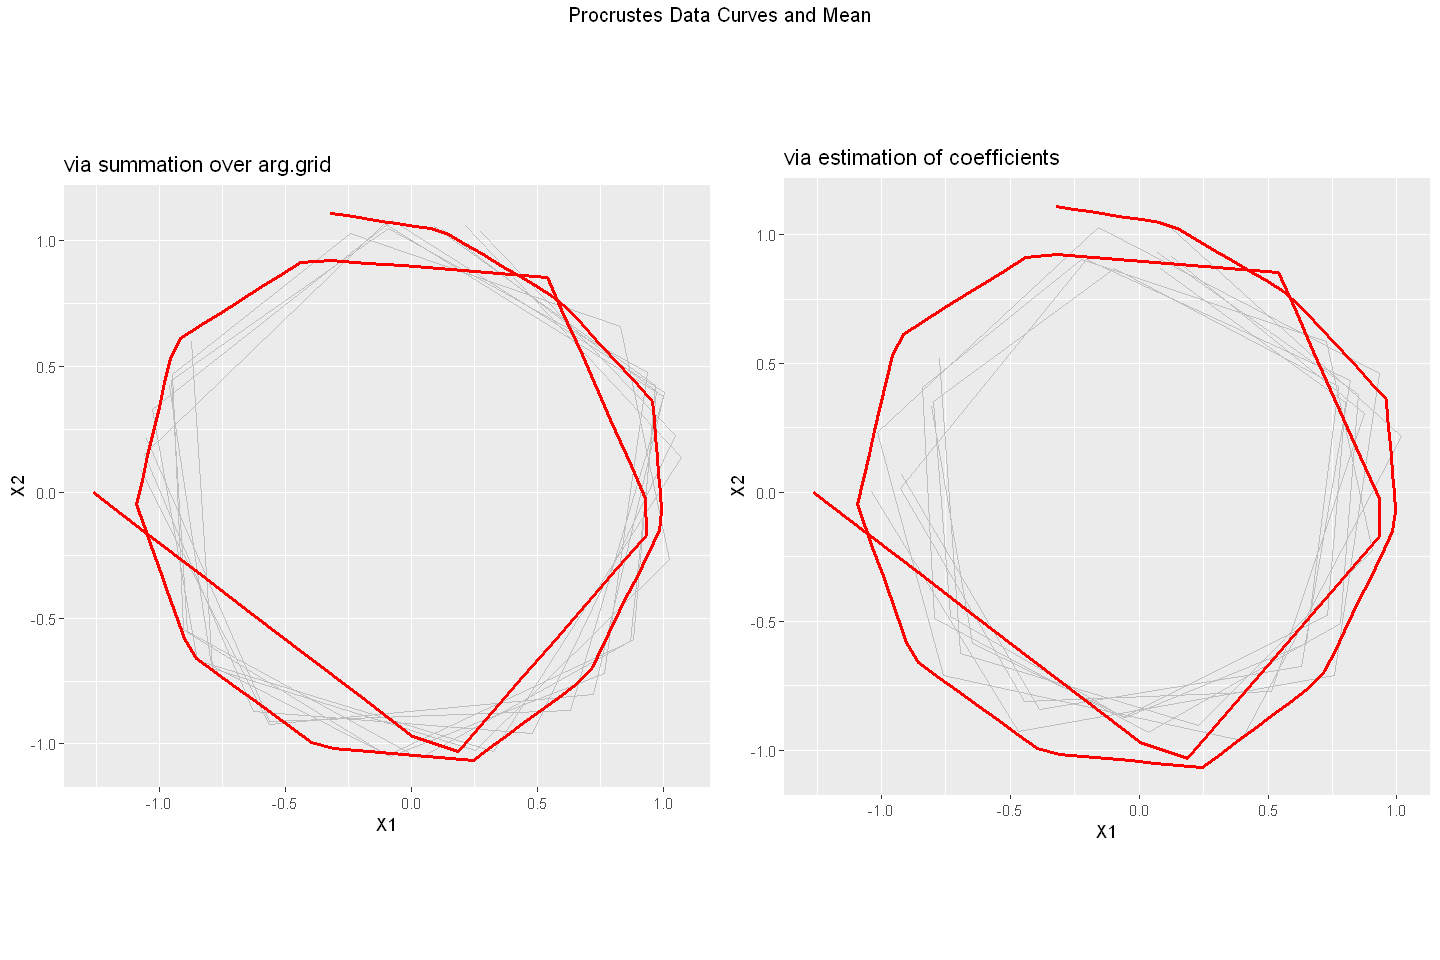

In [441]:
p1 <- ggplot(bind_rows(pfits, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=qt.xy, aes(x=X1, y=X2), color = "red", size = 1) +
    #coord_fixed(ylim=c(-0.012,0.012),xlim=c(-0.012,0.012)) +
    coord_fixed() +
    ggtitle("via summation over arg.grid")
   

p2 <- ggplot(bind_rows(pfits_coef, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=qt.xy, aes(x=X1, y=X2), color = "red", size = 1) +
    #coord_fixed(ylim=c(-0.012,0.012),xlim=c(-0.012,0.012)) +
    coord_fixed() +
    ggtitle("via estimation of coefficients")
    
options(repr.plot.width=12, repr.plot.height=8)
grid.arrange(p1, p2, nrow=1, top="Procrustes Data Curves and Mean")

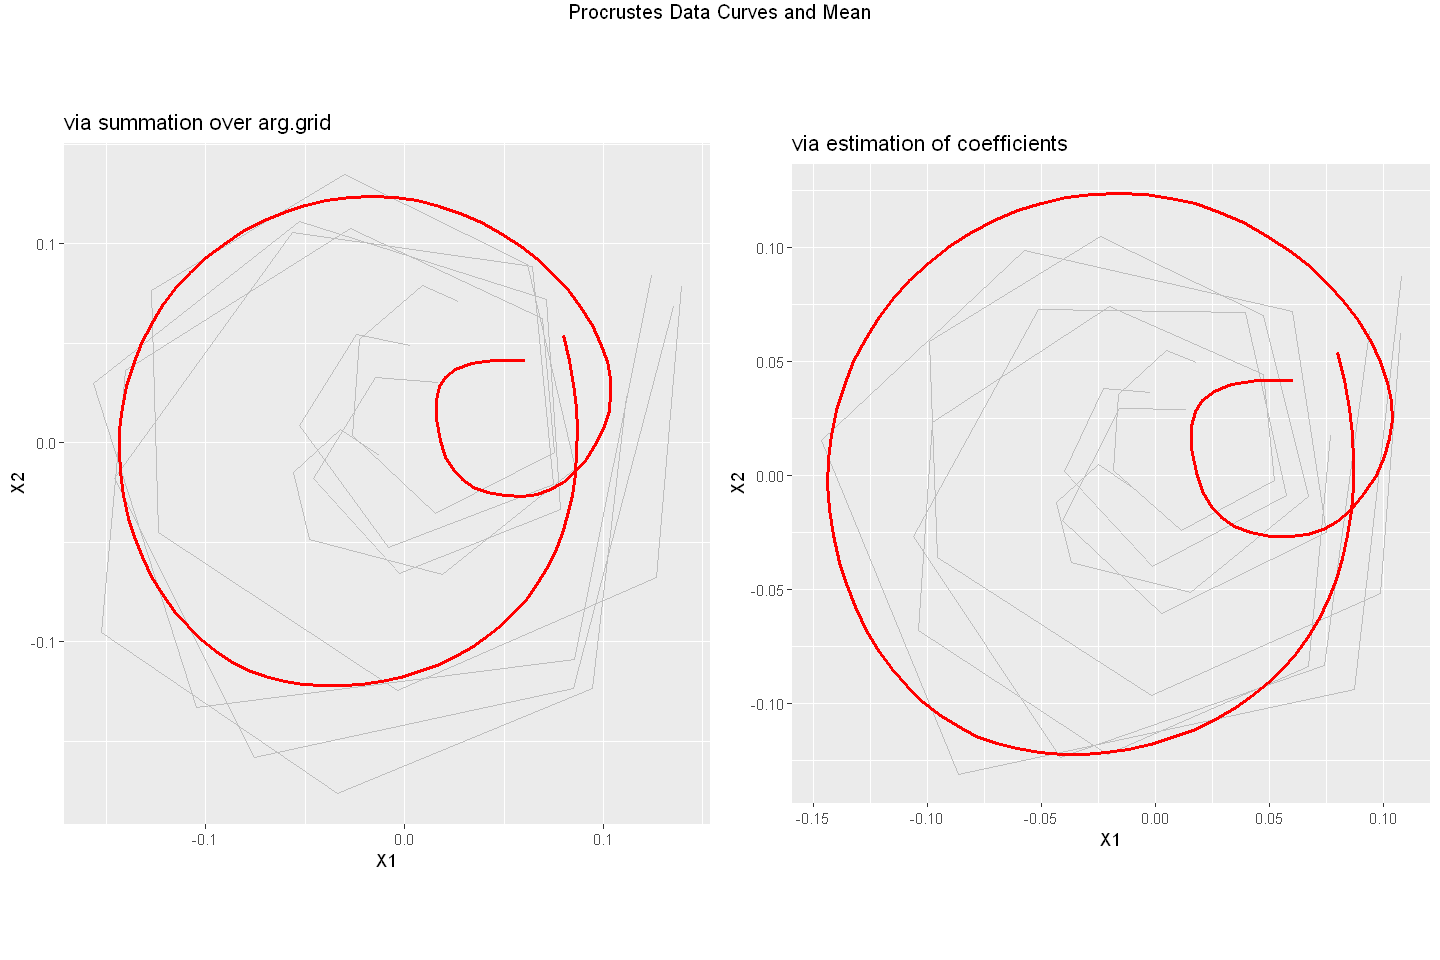

In [442]:
pfits_dta <- lapply(pfits, function(pfit) {
    center_curve(get_points_from_srv(pfit))
})
    
pfits_dta_coef <- lapply(pfits_coef, function(pfit) {
    center_curve(get_points_from_srv(pfit))
})
    
p1 <- ggplot(bind_rows(pfits_dta, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=bt.xy, aes(x=X1, y=X2), color = "red", size = 1) +
    #coord_fixed(ylim=c(-0.012,0.012),xlim=c(-0.012,0.012)) +
    coord_fixed() +
    ggtitle("via summation over arg.grid")
   

p2 <- ggplot(bind_rows(pfits_dta_coef, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=bt.xy, aes(x=X1, y=X2), color = "red", size = 1) +
    #coord_fixed(ylim=c(-0.012,0.012),xlim=c(-0.012,0.012)) +
    coord_fixed() +
    ggtitle("via estimation of coefficients")
    
options(repr.plot.width=12, repr.plot.height=8)
grid.arrange(p1, p2, nrow=1, top="Procrustes Data Curves and Mean")

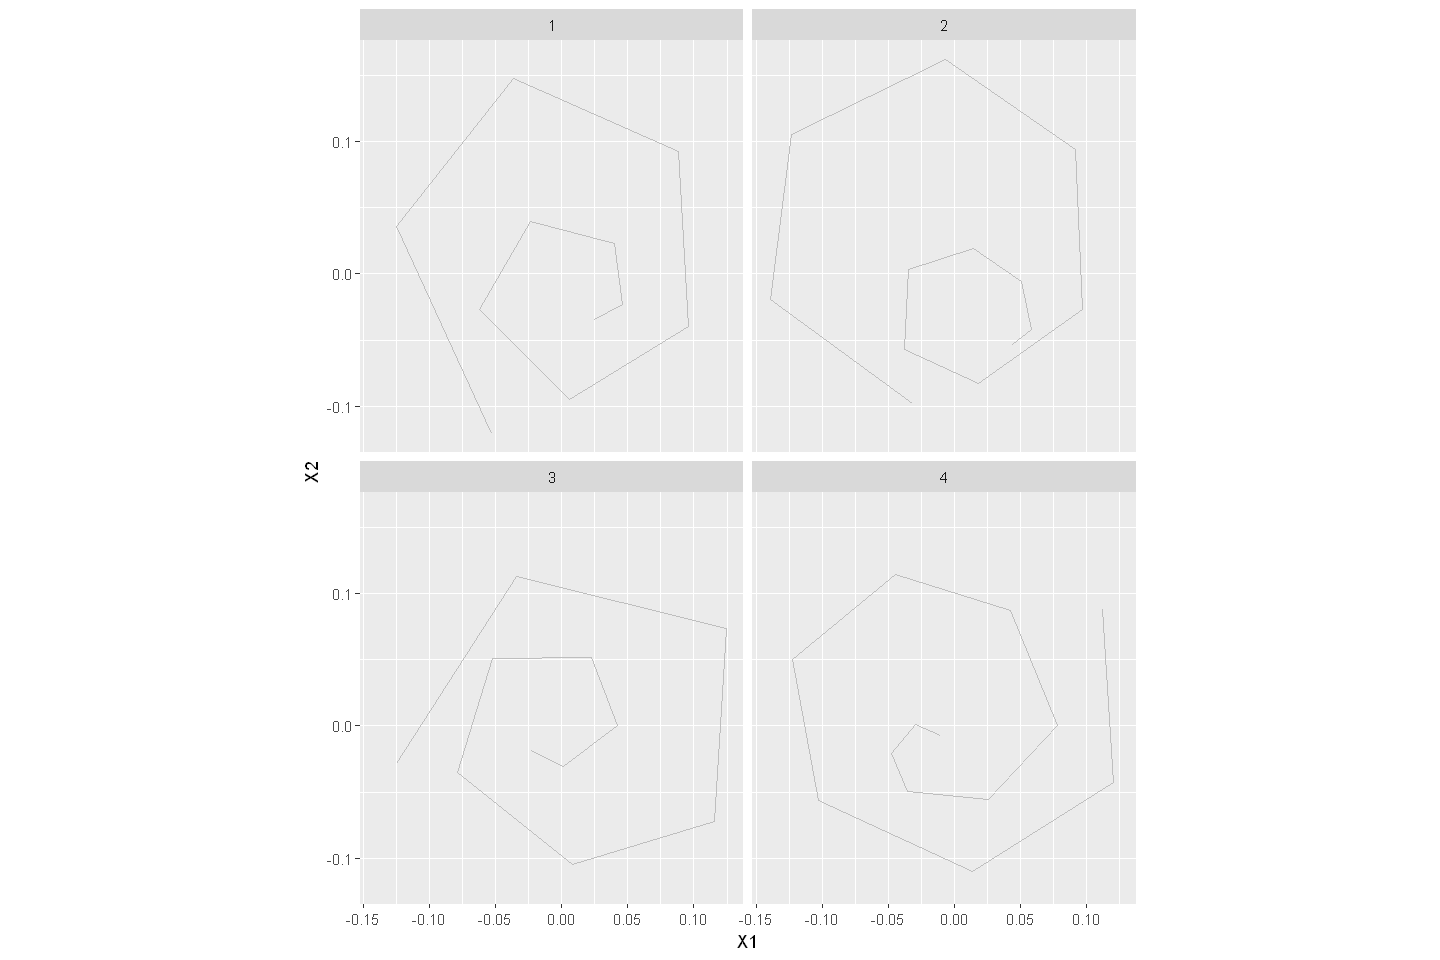

In [443]:
ggplot(bind_rows(data_curves, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    coord_fixed() + 
    facet_wrap(~id)